In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFGridUtils
from geophys_utils import NetCDFLineUtils
from geophys_utils import get_gdal_wcs_dataset, get_gdal_grid_values # N.B: GDAL WCS won't work on Alex's Windows laptop
import matplotlib.pyplot as plt

In [3]:
# Setup proxy as required
GA_STAFF_WIFI = False

if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'

In [4]:
dem_wcs_url = 'http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_Hydro_Enforced/MapServer/WCSServer?service=WCS'

line_nc_path = '/g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_2016_adjusted/netcdf/GSSA_P1255MAG_Marree.nc'
if not os.path.isfile(line_nc_path):
    line_nc_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_2016_adjusted/netcdf/GSSA_P1255MAG_Marree.nc'

grid_nc_path = "/g/data1/rr2/national_geophysical_compilations/IR_gravity_anomaly_Australia_V1/IR_gravity_anomaly_Australia_V1.nc"
if not os.path.isfile(grid_nc_path):
    grid_nc_path = "http://dapds00.nci.org.au/thredds/dodsC/rr2/national_geophysical_compilations/IR_gravity_anomaly_Australia_V1/IR_gravity_anomaly_Australia_V1.nc"

bounds = (137, -29, 138, -28) # Bounding box within survey area

In [5]:
# Initialise NetCDFLineUtils object
# Code is at https://github.com/alex-ip/geophys_utils
line_nc_dataset = netCDF4.Dataset(line_nc_path)
netcdf_line_utils = NetCDFLineUtils(line_nc_dataset)

In [6]:
# Initialise NetCDFGridUtils object
# Code is at https://github.com/alex-ip/geophys_utils
grid_nc_dataset = netCDF4.Dataset(grid_nc_path)
netcdf_grid_utils = NetCDFGridUtils(grid_nc_dataset)

In [7]:
# Open GDAL dataset for DEM WCS
dem_gdal_dataset = get_gdal_wcs_dataset(dem_wcs_url)

In [8]:
# Get all coordinates and data points for line 100060
line_number, line_dict = netcdf_line_utils.get_lines(line_numbers=100060, variables='mag_awags').next()
print line_number, line_dict

coordinates = line_dict['coordinates']
mag_awags = line_dict['mag_awags']

100060 {'mag_awags': array([-97.00695038, -96.98067474, -96.95639038, ..., -52.15274811,
       -52.16643524, -52.17512512], dtype=float32), 'coordinates': array([[ 139.52525 ,  -28.155075],
       [ 139.525249,  -28.155129],
       [ 139.525248,  -28.155183],
       ..., 
       [ 139.504499,  -29.616025],
       [ 139.504498,  -29.616085],
       [ 139.504497,  -29.616144]])}


In [9]:
# Compute cumulative distances in metres for line 100060
utm_distances = netcdf_line_utils.coords2metres(coordinates)
print utm_distances

[  0.00000000e+00   5.98434645e+00   1.19686929e+01 ...,   1.61925609e+05
   1.61932260e+05   1.61938799e+05]


In [10]:
# Obtain values for sample points from gridded dataset
grid_values = np.array(netcdf_grid_utils.get_value_at_coords(coordinates, max_bytes=100))
print grid_values.shape

(25373,)


In [11]:
# Obtain DEM values via WCS
dem_values = get_gdal_grid_values(dem_gdal_dataset, coordinates, netcdf_line_utils.wkt)
print dem_values

[ 23.40055656  23.40055656  23.40055656 ...,  72.32505035  72.32505035
  72.44532776]


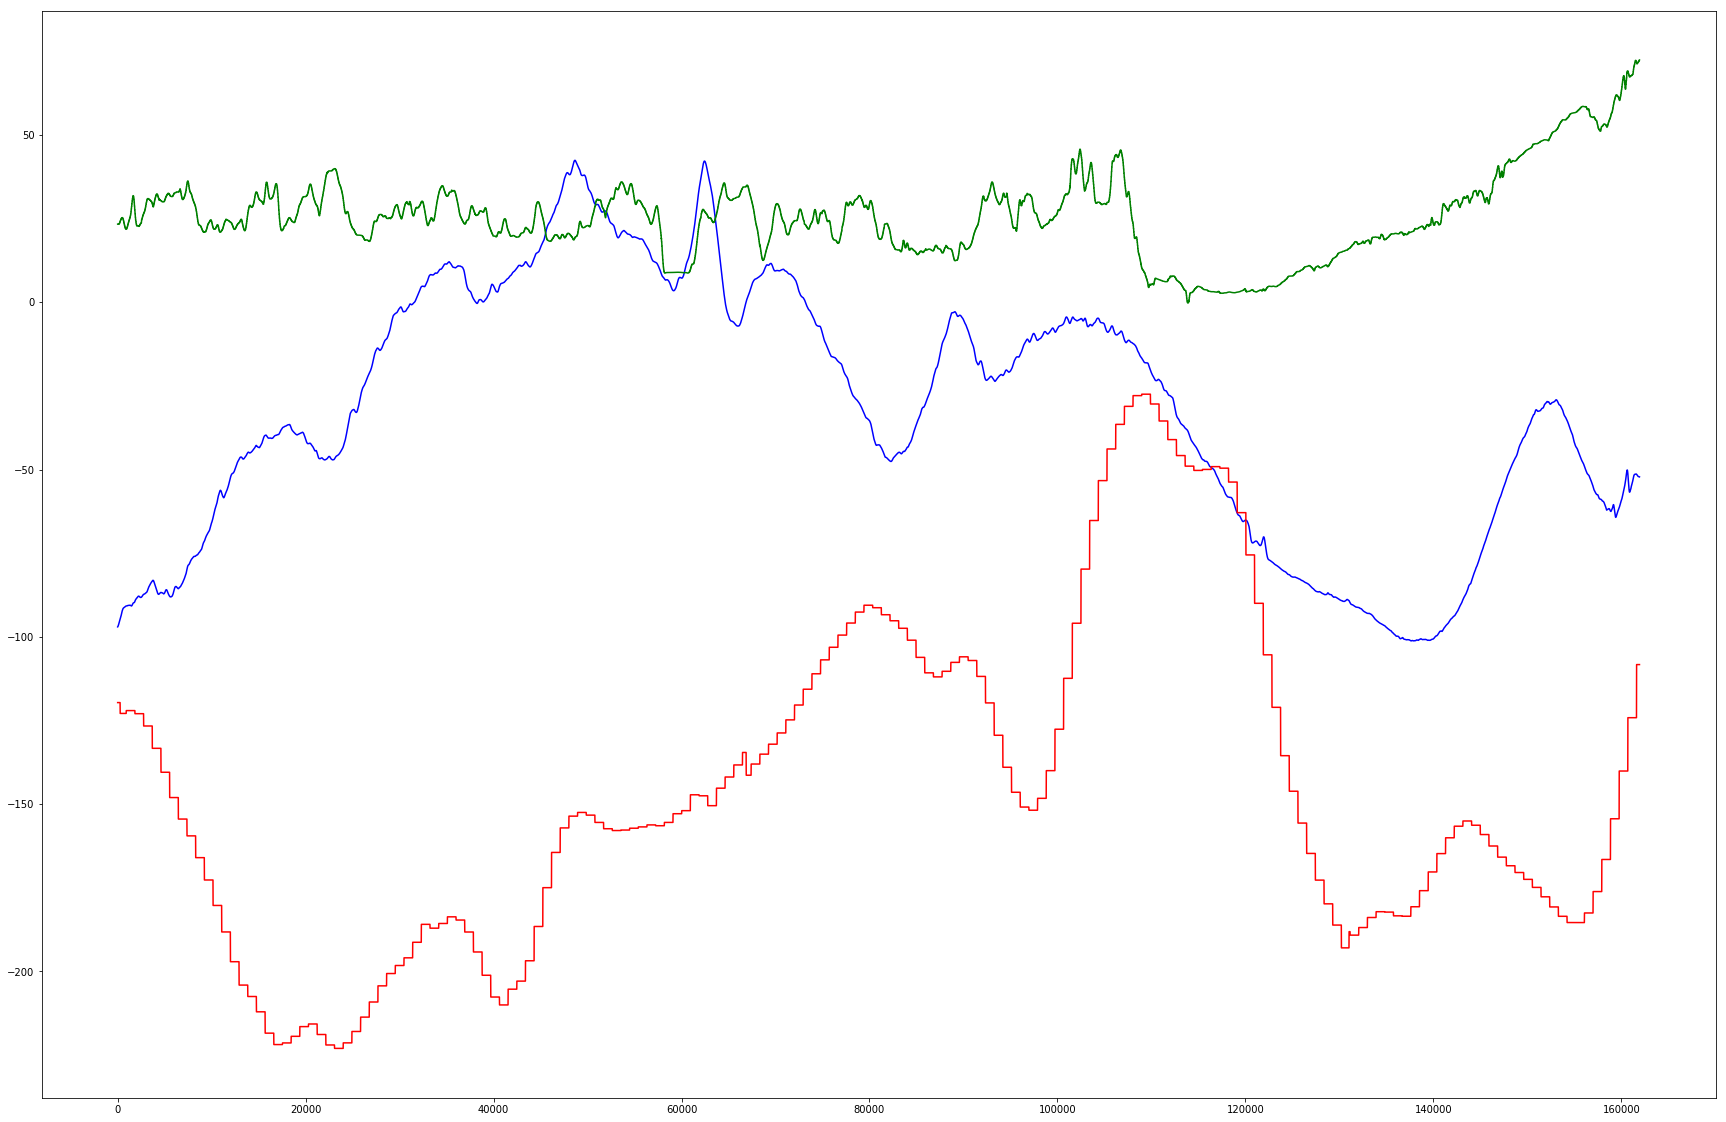

In [12]:
# Plot data points against line distance for line 100060
plt.figure(figsize=(30,20))   
plt.plot(utm_distances, line_dict['mag_awags'], 'b-')        
plt.plot(utm_distances, grid_values, 'r-')
plt.plot(utm_distances, dem_values, 'g-')